<a href="https://colab.research.google.com/github/henriquehsilva/i2a2-brasil-pneumonia-classification/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, Math, IFrame, display

# Exploratory Data Analysis (EDA) - I2A2 - Bone Age Regression


## Overview


One of the main concerns of medicine and legal dentistry is the search for mechanisms that allow the determination of the age of people and, for the development of this work, the hand and wrist region was chosen to determine age and bone development, due to the chronological sequence it presents as well as the number of bones and epiphyses in a not very extensive area, making it possible to perform a single radiographic take, avoiding unnecessary exposure to the patient.

In [3]:
video_ids = ['Zs1oC_upTvM', '_s7B4IjmP8A']

def embed_video(video_ids):
  videos_str = ""
  
  for video_id in video_ids: 
    videos_str += (
      f"<iframe width='560' height='315' src='https://www.youtube.com/embed/{video_id}'.format(test)" \
       "frameborder='0' allow='accelerometer; autoplay; encrypted-media; gyroscope;" \
       " picture-in-picture' allowfullscreen></iframe>"
      )
    
  return HTML(videos_str)

embed_video(video_ids)

### Context

> Create a model to predict children's bone age by x-ray of the hand.

- The training data set comes from the RSNA 2017 competition
- The test data set is from a Brazilian hospital

### Primary directives:

- Generalize the model to deal with the change in distribution between data sets;
- The **TRAINING data set contains only left-hand images**, the **TEST data set contains some images with both hands**;
- Adjust the model to deal with the variance of results between patients of opposite sexes;

After studying the master's thesis of dentist Mauricio Roberto Bosquiero: [DETERMINAÇÃO DA MATURIDADE ESQUELÉTICA E ESTIMATIVA DA IDADE ATRA VÊS DE RADIOGRAFIAS CARPAIS](https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/docs/tese_mauricio_roberto.pdf)., we can arrive at a third directive, referring to the clear variance of skeletal maturity of patients of the same opposite age and sex.

In [4]:
!pip install sweetviz

# Setup

In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print(f"TensorFlow V{tf.__version__} 🦾")

TensorFlow V2.2.0 🦾


In [37]:
# Auxiliary libraries
import os
import functools
import pandas as pd
import numpy as np
import requests
import pathlib
import sweetviz
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
from sklearn.model_selection import train_test_split
from datetime import datetime

# Configure development and test suites

**Google Cloud Storage** was chosen as the centralizer of support files, as well as for the new files and reports generated because it offers availability and the ability to use it to work in a distributed manner.

In [7]:
from keras.utils import get_file

BONE_AGE_DATASET_URL = 'https://storage.googleapis.com/bone-age-regression.henriquesilva.dev'

path_to_zip = get_file('images.zip', origin = f"{BONE_AGE_DATASET_URL}/images.zip", archive_format = 'zip', extract = True)

train_data_file = get_file('train.csv', origin = f"{BONE_AGE_DATASET_URL}/train.csv", extract = False)
test_data_file = get_file('test.csv', origin = f"{BONE_AGE_DATASET_URL}/test.csv", extract = False)

raw_train_df = pd.read_csv(train_data_file)
test_df = pd.read_csv(test_data_file)

# Improve data frame 

In [8]:
# Category
raw_train_df['boneage_category'] = pd.cut(raw_train_df['boneage'], 10)

# Z-Score
boneage_mean = raw_train_df['boneage'].mean()
boneage_div = 2*raw_train_df['boneage'].std()
raw_train_df['boneage_zscore'] = raw_train_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)

# Male?
raw_train_df['male'] = raw_train_df['patientSex'].map(lambda x: np.bitwise_xor(x == 'F', 1))

def image_link_generator(path_uri, file_name):
  image_link = f"{path_uri}/images/{file_name}"
  return image_link

# Image link
raw_train_df['image_link'] = raw_train_df['fileName'].map(
  lambda file_name: image_link_generator(BONE_AGE_DATASET_URL, file_name)
)

## Preview

In [9]:
HTML(raw_train_df.head(5).to_html(render_links=True, escape=False))

,fileName,patientSex,boneage,boneage_category,boneage_zscore,male,image_link
0,1377.png,F,180,"(159.9, 182.6]",0.639590,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1377.png
1,1378.png,F,12,"(0.773, 23.7]",-1.400135,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1378.png
2,1379.png,F,94,"(91.8, 114.5]",-0.404555,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1379.png
3,1380.png,M,120,"(114.5, 137.2]",-0.088883,1,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1380.png
4,1381.png,F,82,"(69.1, 91.8]",-0.550249,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1381.png


# Split the development dataset

In [10]:
train_df, valid_df = train_test_split(
  raw_train_df, 
  test_size = 0.25, 
  random_state = 2018,
  stratify = raw_train_df['boneage_category']
)

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 9458 validation 3153


In [12]:
columns = ['fileName', 'boneage_category', 'image_link']
train = train_df.drop(columns, axis=1)
valid = valid_df.drop(columns, axis=1)

In [13]:
data_report = sweetviz.compare([train, "Train"], [valid, "Valid"], "boneage")

:FEATURES DONE:                    |█████████████████████| [100%]   00:05  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!


In [16]:
def report_generate(data_report):
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d%H%M%S")

    report_file = f"{timestamp}_report_view.html"

    data_report.show_html(report_file)

In [17]:
report_generate(data_report)

Report 20200730231510_report_view.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


# Images analysis

In [46]:
data_dir = pathlib.Path("/home/henriquesilva/.keras/datasets/images/")
raw_train_df['path'] = raw_train_df['fileName'].map(lambda fn: data_dir)

In [47]:
image_count = len(list(data_dir.glob('*.png')))
display(HTML(f"<h1>{image_count} images</h1>"))

# Training base images

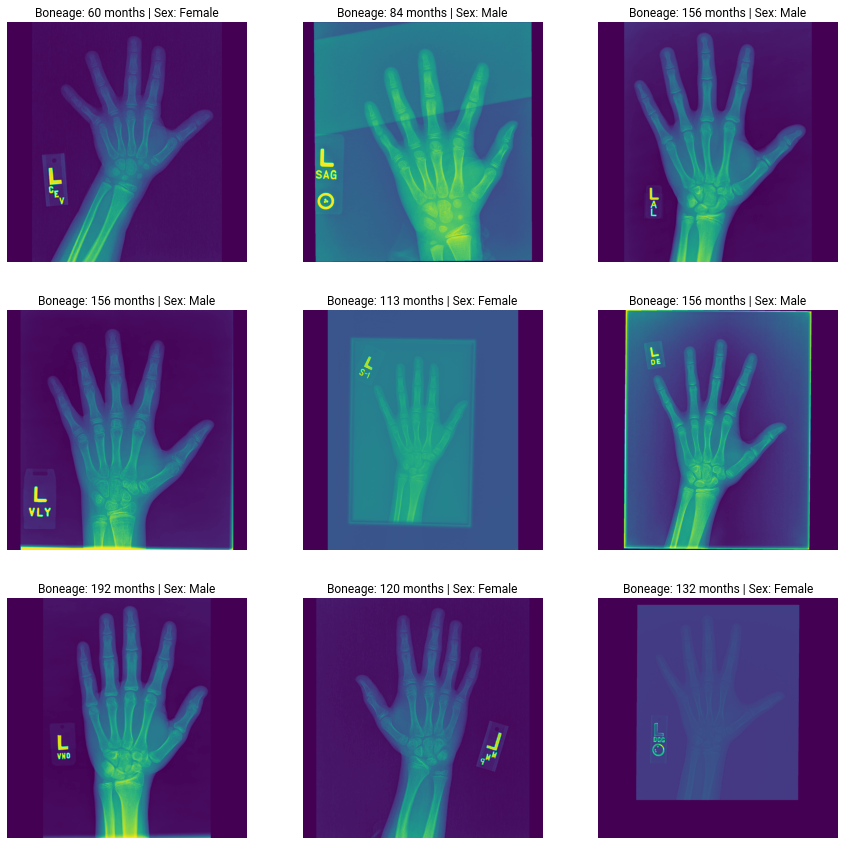

In [48]:
plt.figure(figsize=(15, 15))
row, col = 3, 3
i = 0

for fileName, patientSex, boneage in raw_train_df[['fileName','patientSex','boneage']].sample(9).values:
    i += 1
    file_id = str(fileName)
    image = Image.open(f"{data_dir}/{file_id}")
    
    plt.subplot(row, col, i)
    plt.title(f"Boneage: {boneage} months | Sex: {'Male' if patientSex == 'M' else 'Female'}")
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

# Test base images

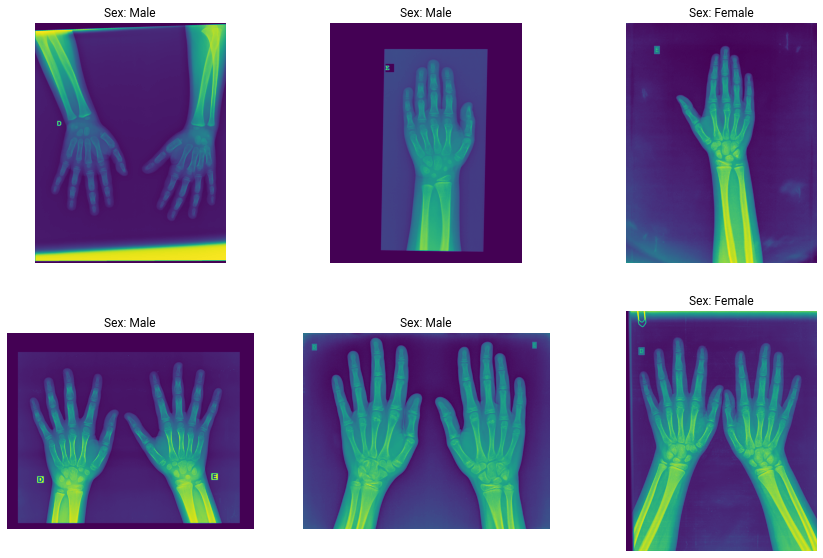

In [49]:
plt.figure(figsize=(15, 15))
row, col = 3, 3
i = 0

for fileName, patientSex in test_df[['fileName','patientSex']].sample(6).values:
    i += 1
    file_id = str(fileName)
    image = Image.open(f"{data_dir}/{file_id}")
    
    plt.subplot(row, col, i)
    plt.title(f"Sex: {'Male' if patientSex == 'M' else 'Female'}")
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

In [52]:
# maior idade do dataset
print('MAX age: ' + str(raw_train_df['boneage'].max()) + ' months')

# menor idade do dataset
print('MIN age: ' + str(raw_train_df['boneage'].min()) + ' months')

# idade media
mean_bone_age = raw_train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

# mediana
print('median: ' +str(raw_train_df['boneage'].median()))

# desvio padrão das idades
std_bone_age = raw_train_df['boneage'].std()

# modelos podem performar melho quando são normalizados os dados
raw_train_df['bone_age_z'] = (raw_train_df['boneage'] - mean_bone_age)/(std_bone_age)

# visualizando o dataset novamente
HTML(raw_train_df.head(5).to_html(render_links=True, escape=False))

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0


,fileName,patientSex,boneage,boneage_category,boneage_zscore,male,image_link,path,bone_age_z
0,1377.png,F,180,"(159.9, 182.6]",0.639590,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1377.png,/home/henriquesilva/.keras/datasets/images,1.279181
1,1378.png,F,12,"(0.773, 23.7]",-1.400135,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1378.png,/home/henriquesilva/.keras/datasets/images,-2.800269
2,1379.png,F,94,"(91.8, 114.5]",-0.404555,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1379.png,/home/henriquesilva/.keras/datasets/images,-0.809109
3,1380.png,M,120,"(114.5, 137.2]",-0.088883,1,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1380.png,/home/henriquesilva/.keras/datasets/images,-0.177766
4,1381.png,F,82,"(69.1, 91.8]",-0.550249,0,https://storage.googleapis.com/bone-age-regression.henriquesilva.dev/images/1381.png,/home/henriquesilva/.keras/datasets/images,-1.100498
